In [113]:
# #install jupyter lib
# %pip install jupyter

#uncomment to install netgraph library
# %pip install netgraph

# Import the NetworkX package
import networkx as nx


### Degree Centrality of All Nodes
`neighborNodesDegree(G, U)` accepts a graph `G` and individual neighbor nodes `U` of node `V` and returns the sum of the degrees of the neighbor node `U` and its neighbors.

`centralityOfNodes(G)` accepts a graph `G` and return a dictionary of all nodes `V` and their centralities in the graph.

In [114]:
def neighborNodesDegree(G, U):
    degU = G.degree(U) #degree of U

    for w in G.neighbors(U):
        degU += G.degree(w)
    
    return degU

def centralityOfNodes(G):
    centralities = dict()

    #find the centralities of all nodes
    for V in G.nodes():
        degV = G.degree(V) #degree of V

        for U in G.neighbors(V):
            degV += neighborNodesDegree(G, U)
        
        #save centrality of each V
        centralities[V] = degV
    
    return centralities
    

### Fuzzy Relation and NGC
`temporalFuzzyRelations(G, V)` accepts a graph `G` and a node `V` and returns a list of the fuzzy relations of all neighbors of `V`

In [115]:
import operator

def temporalFuzzyRelations(G, V):
    Xtemp = 0
    #store not visited nodes
    tempFuzzies = dict()
    
    len_vn = len(sorted(G.neighbors(V))) #length of node v neighbors

    for X in G.neighbors(V):
        vx_cn = nx.common_neighbors(G, V, X) #common neighbors(cn) of both V and X
        Xtemp = (1 + len(sorted(vx_cn))) / len_vn
        tempFuzzies[X] = Xtemp

    return tempFuzzies

def findNGCandFuzzyRelation(G, V):
    findtag = False
    W = V
    fuzzyrelation = 0
    closeTable = dict()
    
    #retrieve dictionary of node centralities
    nodeCentralities = centralityOfNodes(G) 

    #retrieve dictionary of temporal fuzzy relations
    openTable = temporalFuzzyRelations(G, V)

    while len(openTable) != 0:
        #take node with maximum temporal fuzzy relation
        C = max(openTable.items(), key=operator.itemgetter(1))[0]

        #if we don't have an NGC
        if findtag == False:
            if nodeCentralities.get(C, 0) > nodeCentralities.get(V, 0):
                W = C
                fuzzyrelation = openTable.get(C)
                findtag = True
        else:
            if openTable.get(C) < fuzzyrelation:
                break

            if nodeCentralities.get(C, 0) > nodeCentralities.get(W, 0):
                W = C
                fuzzyrelation = openTable.get(C)
    
        closeTable[C] = openTable.get(C)

        #remove node and its value but return value -> default to return None to prevent KeyError
        CtmpFR = openTable.pop(C, None) 

        len_cn = len(sorted(G.neighbors(C))) #length of node c neighbors
        currentfr = 0

        for Y in G.neighbors(C):
            cy_cn = nx.common_neighbors(G, C, Y) #common neighbors(cn) of both C and Y
            currentfr = (1 + len(sorted(cy_cn))) / len_cn
            currentfr *= CtmpFR

            openTableContainsY = openTable.get(Y, None)
            closeTableContainsY = closeTable.get(Y, None)
            if openTableContainsY == None and closeTableContainsY == None:
                openTable[Y] = currentfr
            elif openTableContainsY != None:
                if currentfr > openTableContainsY:
                    openTable[Y] = currentfr
            elif closeTableContainsY != None:
                if currentfr > closeTableContainsY:
                    openTable[Y] = currentfr
                    closeTable.pop(Y, None)

    return W, fuzzyrelation

### Constructing Community Structure
The function `constructCommunityStructure(G, delta)` takes in a graph `G` and a threshold value `delta` and returns a list of recognized communities in the network. The `delta` value controls how many communities can be recognized and it is picked from the decision graphs constructed from the network.

In [116]:
def constructCommuityStructure(G, delta):
    #retrieve and sort nodes' centralities
    centralities = centralityOfNodes(G) 
    centralities =dict(sorted(centralities.items(), key=lambda item: item[1], reverse=True))

    communities = dict()
    comnumber = -1
    
    for V in centralities:
        ngc, fr = findNGCandFuzzyRelation(G, V)
        if fr < delta:
            comnumber += 1
            communities[comnumber] = [V]
        else:
            #find the community number of ngc
            for comnum, com in communities.items():
                if ngc in com:
                    #add V to the community ngc of V belongs
                    communities[comnum].append(V)
                    break
            
    return communities


### Util Functions
The function `draw(G, refinedData, datasetName)` visualizes the constructed communities in a graph using the [Netgraph](https://netgraph.readthedocs.io/en/stable/) library. It accepts a graph `G`, a `refinedData` from the function `nodeToCommunity(G, delta)` that returns a list of nodes and their associated communities, and a string `datasetName` which is the name of the dataset used.

In [117]:
# import matplot library
import matplotlib.pyplot as plt

#install and import netgraph
from netgraph import Graph

# for Notebook
%matplotlib inline

def draw(G, refinedData, datasetName):
    #colors for various communities
    community_to_color = {
        0 : 'tab:blue', 1 : 'tab:orange', 2 : 'tab:green', 3 : 'tab:red', 4 : 'tab:purple',
        5 : 'tab:cyan', 6 : 'tab:brown', 7 : 'tab:pink', 8 : 'tab:olive', 9 : 'yellow', 
        10 : 'aqua', 11 : 'tab:grey', 12 : 'maroon', 13 : 'lime', 14 : 'olive', 15 : 'navy', 
        16 : 'coral', 17 : 'indigo', 18 : 'red',19 : 'green' 
    }
    
   
    #extract node_to_community, original communities and delta values
    node_to_community, communities, delta = refinedData
    
    #get number of communities detected
    com_len = len(communities)
    
    try:
        node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()}
            
        #set node size and scale based on number of communities
        #to give some spacing/scaling to dense communities
        if com_len > 4:
            node_size = 7.0
            scale = (2.0, 2.0)
        else:
            node_size = 8.0
            scale = (1.2, 1.2)

        #maintain a window scale of 2.0 for networks with over 50 nodes    
        if len(node_to_community) > 50:
            scale = (2.0, 2.0)
            
        #set netgraph graph parameters    
        Graph(G,
        node_color=node_color, node_edge_width=0, edge_alpha=0.4, node_size=node_size,
        node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
        edge_layout='straight', edge_layout_kwargs=dict(k=2000), node_labels=True,
        edge_color="tab:grey", scale=scale
        )

        plt.title("{}: {} communities with delta={}".format(datasetName, com_len, delta))
        
        #save image of community graph
        filename = datasetName.replace(" ", "_")+"_delta_"+str(delta)
        plt.savefig("graphs/communities/{}".format(filename.lower()+".png"), format="PNG", dpi=400)
        plt.show()
    except:
        print("Delta: {} {} Communities Detected: {}".format(delta, datasetName, com_len))
              
        print("Cannot visualize more than 20 communities. Reduce Delta value")
    


def nodeToCommunity(G, delta):
    communities = constructCommuityStructure(G, delta)
    node_to_community = dict()

    #flatten communities to nodes
    for comnum, com in communities.items():
        for node in com:
            node_to_community[node] = comnum
            
    return node_to_community, communities, delta

### Dataset Setup and Visualization
Some datasets needed to be converted to have their integer labels instead of string labels to aid in readability of the graphs.

Change the decimal values in the `nodeToCommunity(G, 0.x)` to realize different communities.

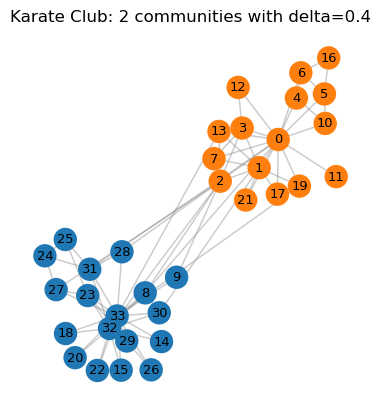

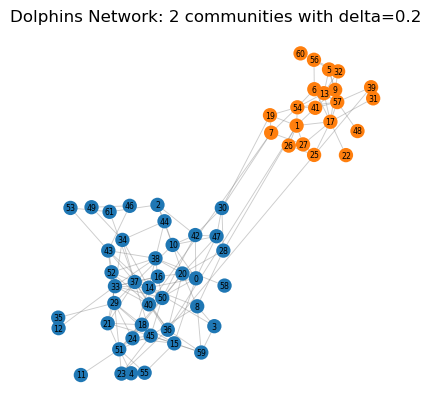

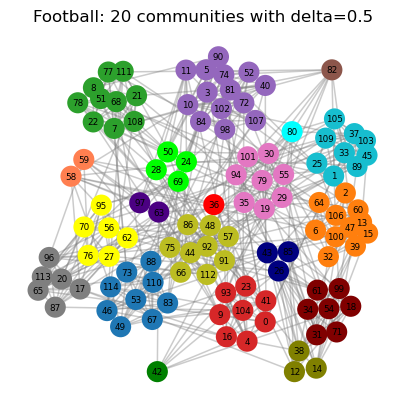

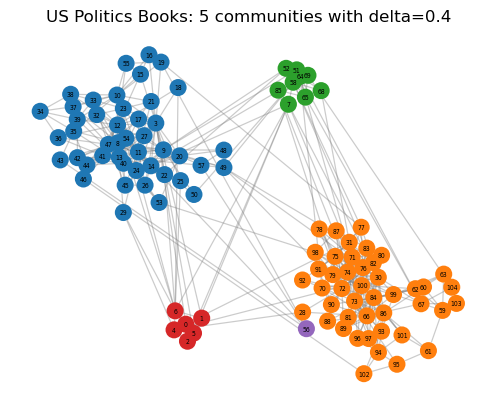

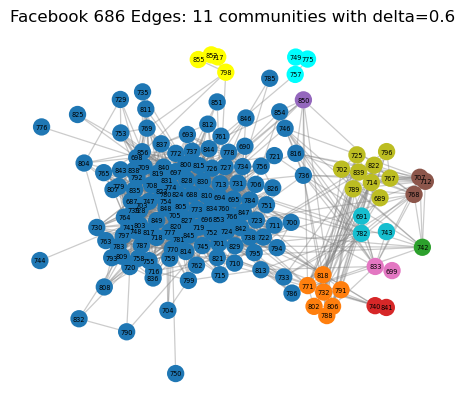

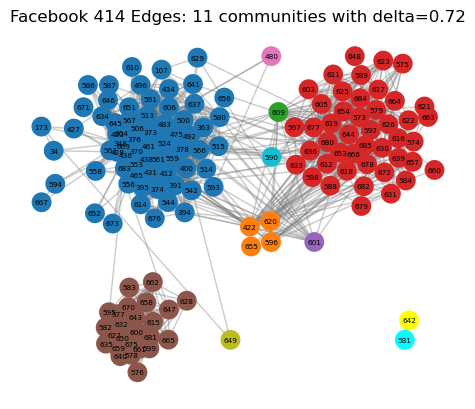

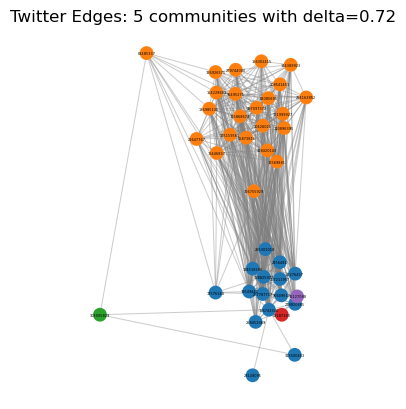

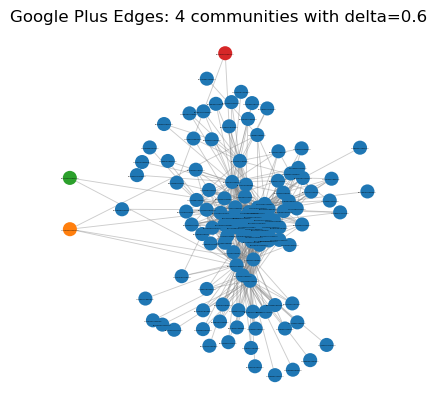

In [118]:
#DATASETS AND GRAPHS
#Karate Club
K = nx.karate_club_graph()
draw(K, nodeToCommunity(K, 0.4), "Karate Club")

# #Dolphin
D = nx.read_gml("datasets/dolphins.gml")
D = nx.convert_node_labels_to_integers(D,first_label=0)
draw(D, nodeToCommunity(D, 0.2), "Dolphins Network")

# #Football
F = nx.read_gml("datasets/football.gml")
F = nx.convert_node_labels_to_integers(F,first_label=0)
draw(F, nodeToCommunity(F, 0.5), "Football")

# #US Politics Books
P = nx.read_gml("datasets/us_politics_books.gml")
P = nx.convert_node_labels_to_integers(P,first_label=0)
draw(P, nodeToCommunity(P, 0.40), "US Politics Books")

# #Facebook
FB6 = nx.read_edgelist("datasets/facebook686.edges")
draw(FB6, nodeToCommunity(FB6, 0.6), "Facebook 686 Edges")

FB4 = nx.read_edgelist("datasets/facebook414.edges")
draw(FB4, nodeToCommunity(FB4, 0.72), "Facebook 414 Edges")

# #Twitter
T = nx.read_edgelist("datasets/twitter.edges")
draw(T, nodeToCommunity(T, 0.72), "Twitter Edges")

# Google Plus
GP = nx.read_edgelist("datasets/googleplus.edges")
draw(GP, nodeToCommunity(GP, 0.6), "Google Plus Edges")

### Constructing Decision Graphs
Decision graphs help in detecting the communities by aiding us to choose a delta value.

The function `decisionGraphs(G, datasetName)` takes a graph `G` and a `datasetName` and visualize a decision graph of the network.

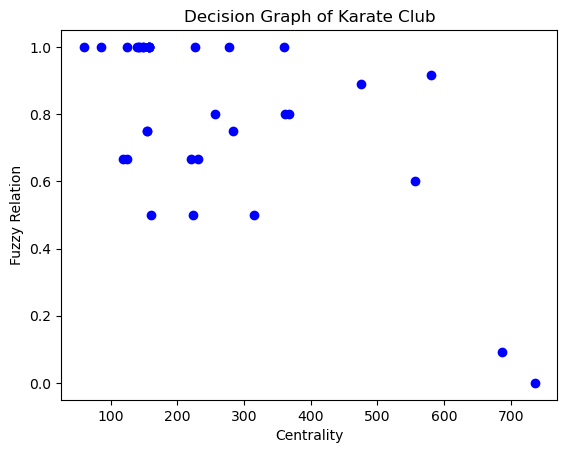

In [119]:
def decisionGraphs(G, datasetName):
    fuzzies = list()

    #retrieve fuzzy relations of all nodes
    for V in G.nodes():
        ngc, fr = findNGCandFuzzyRelation(G, V)
        fuzzies.append(fr)

    #get centrality of all nodes
    centralities = list(centralityOfNodes(G).values())

    plt.title("Decision Graph of {}".format(datasetName))
    plt.xlabel('Centrality')
    plt.ylabel('Fuzzy Relation')
    plt.scatter(centralities, fuzzies, c="b")
    
    # save image of decision graph
    filename = datasetName.replace(" ", "_").lower()
    plt.savefig("graphs/decisions/{}".format(filename+"_decision_graph"+".png"), format="PNG", dpi=400)


K = nx.karate_club_graph()
decisionGraphs(K, "Karate Club")

# D = nx.read_gml("datasets/dolphins.gml")
# D = nx.convert_node_labels_to_integers(D,first_label=0)
# decisionGraphs(D, "Dolphins Network")

# F = nx.read_gml("datasets/football.gml")
# F = nx.convert_node_labels_to_integers(F,first_label=0)
# decisionGraphs(F, "Football")

# P = nx.read_gml("datasets/us_politics_books.gml")
# P = nx.convert_node_labels_to_integers(P,first_label=0)
# decisionGraphs(P, "US Politics Books")

# FB = nx.read_edgelist("datasets/facebook686.edges")
# # FB = nx.read_edgelist("datasets/facebook414.edges")
# FB = nx.convert_node_labels_to_integers(FB,first_label=0)
# decisionGraphs(FB, "Facebook 686 Edges")

# T = nx.read_edgelist("datasets/twitter.edges")
# decisionGraphs(T, "Twitter")

# GP = nx.read_edgelist("datasets/googleplus.edges")
# decisionGraphs(GP, "Google Plus")
